In [3]:
from glob import glob
import json
import os
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
# import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [4]:
sys.path.append(r'C:\Users\lesliec\code')

In [5]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [7]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [10]:
%matplotlib ipympl

#### Plot electrodes

Text(0.5, 1.0, 'NeuroNexus numbering')

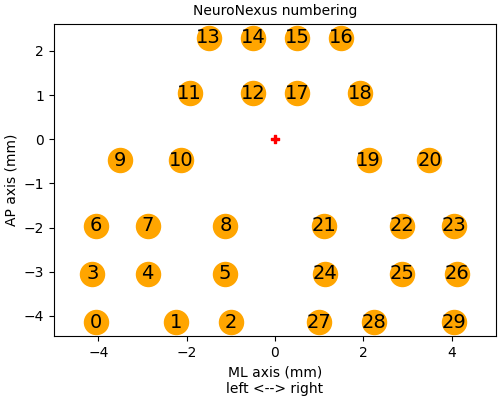

In [11]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], s=300, color='orange')
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    ax.annotate(str(ind),  xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('NeuroNexus numbering')

### All mice

In [6]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses')

In [7]:
all_exps = {
    '645606': [
        r'E:\GAT1_EEG_pilot\mouse645606\signal_test_2022-11-18_14-49-19\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse645606\spontEEG1_2022-11-22_17-12-47\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_estim_2022-12-20_12-26-39\experiment1\recording1'
    ],
    '644565': [
        r'E:\GAT1_EEG_pilot\mouse644565\signal_test_2022-11-30_15-41-47\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse644565\spontEEG1_2022-12-07_16-07-14\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1'
    ],
    '672785': [
        r'E:\GAT1_EEG_pilot\mouse672785\visual_2023-06-27_13-19-27\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\recording1',
    ],
    '672789': [
        r'E:\GAT1_EEG_pilot\mouse672789\visual_2023-06-28_13-08-49\experiment1\recording1',
        r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1',
    ],
}

In [8]:
# all_subjects = {}
all_sub_data = []
for mouse, explist in all_exps.items():
    for recfolder in explist:
        print('{} : {}'.format(mouse, recfolder))
        exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)
        exp_tag = exp.experiment_folder[
            exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
        
        auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
        autoSWD_df = pd.read_pickle(auto_annot_file)
        
        eeg_data, eeg_ts = exp.load_eegdata()
        
        rec_duration = (eeg_ts[-1] - eeg_ts[0]) / 60
        num_SWDs = len(autoSWD_df)
        mean_SWD_dur = np.mean(autoSWD_df['duration'].values)
        min_SWD_dur = np.min(autoSWD_df['duration'].values)
        max_SWD_dur = np.max(autoSWD_df['duration'].values)
        time_in_SWD = np.sum(autoSWD_df['duration'].values) / 60
        fract_in_SWD = time_in_SWD / rec_duration
        
        all_sub_data.append(
            [mouse, exp_tag, rec_duration, num_SWDs, mean_SWD_dur, min_SWD_dur, max_SWD_dur, time_in_SWD, fract_in_SWD]
        )
        print('')

645606 : E:\GAT1_EEG_pilot\mouse645606\signal_test_2022-11-18_14-49-19\experiment1\recording1
Experiment type: sensory stimulation

645606 : E:\GAT1_EEG_pilot\mouse645606\spontEEG1_2022-11-22_17-12-47\experiment1\recording1
No *stim* files were found.
Experiment type: spontaneous

645606 : E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_estim_2022-12-20_12-26-39\experiment1\recording1
Experiment type: electrical stimulation

644565 : E:\GAT1_EEG_pilot\mouse644565\signal_test_2022-11-30_15-41-47\experiment1\recording1
Experiment type: sensory stimulation

644565 : E:\GAT1_EEG_pilot\mouse644565\spontEEG1_2022-12-07_16-07-14\experiment1\recording1
No *stim* files were found.
Experiment type: spontaneous

644565 : E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1
Experiment type: electrical stimulation

672785 : E:\GAT1_EEG_pilot\mouse672785\visual_2023-06-27_13-19-27\experiment1\recording1
Experiment type: sensory stimulation

672785 : E:\GAT1_EEG_pilot\

In [9]:
all_mouse_data = pd.DataFrame(
    all_sub_data,
    columns=['mouse', 'exp', 'exp_duration_min', 'num_SWDs', 'avg_duration_s', 'min_duration_s', 'max_duration_s', 'time_in_SWD_min', 'fract_in_SWD']
)

In [10]:
all_mouse_data

,mouse,exp,exp_duration_min,num_SWDs,avg_duration_s,min_duration_s,max_duration_s,time_in_SWD_min,fract_in_SWD
0,645606,signal_test,15.187623,127,2.942734,0.528402,11.585237,6.228788,0.410123
1,645606,spontEEG1,60.265814,682,2.249611,0.501200,9.151944,25.570584,0.424297
2,645606,EEGNPXspont_estim,73.081188,829,2.847728,0.510795,11.463196,39.346108,0.538389
3,644565,signal_test,28.620809,393,1.711606,0.504805,8.605197,11.211018,0.391709
4,644565,spontEEG1,60.677090,891,1.966451,0.507197,9.165893,29.201795,0.481266
5,644565,EEGNPXspont_estim,72.507730,1049,1.390987,0.500401,6.374039,24.319094,0.335400
6,672785,visual,70.254891,698,3.223581,0.510401,17.867111,37.500992,0.533785
7,672785,EEGNPXspont_estim,118.335069,1052,0.916986,0.500400,3.010003,16.077825,0.135867
8,672789,visual,70.094446,1015,1.376136,0.500000,7.628356,23.279636,0.332118
9,672789,EEGNPXspont_estim,110.045831,707,0.761746,0.500001,2.218394,8.975910,0.081565


In [11]:
SWDgroup_data_file = os.path.join(plotsavedir, r'pilotSWDstats.csv')
all_mouse_data.to_csv(SWDgroup_data_file, index=False)